In [1]:
import warnings
import time
import sys
import datetime
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocessing(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    for col in ['category_3']:
        df[col] = df[col].map({'A':1, 'B':2,'C':3})
    return df

def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (pd.Timestamp('2018-02-01') - df['first_active_month']).dt.days
    return df

In [3]:
# データの読み込み
path_new = '../../../../data/raw/new_merchant_transactions.csv'
path_hist = '../../../../data/raw/historical_transactions.csv'
path_train = '../../../../data/raw/train.csv'
path_test = '../../../../data/raw/test.csv'

new = pd.read_csv(path_new, parse_dates=['purchase_date'])
hist = pd.read_csv(path_hist ,parse_dates=['purchase_date'])

new = preprocessing(new)
hist = preprocessing(hist)

new = reduce_mem_usage(new)
hist = reduce_mem_usage(hist)

train = pd.read_csv(path_train, parse_dates=['first_active_month'])
test = pd.read_csv(path_test, parse_dates=['first_active_month'])

target = train['target']
#del train['target']

Mem. usage decreased to 76.76 Mb (63.4% reduction)
Mem. usage decreased to 1193.84 Mb (61.6% reduction)


In [5]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_0618.csv'
train = pd.read_csv(path_train_prepro)
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'elapsed_time', 'hist_frequency', 'hist_amount_total',
       'hist_amount_mean', 'hist_merchant_category_nu',
       'hist_merchant_category_mode', 'hist_city_nu', 'hist_city_mode',
       'hist_state_nu', 'hist_state_mode', 'hist_date_min', 'hist_date_max',
       'hist_installments_mean', 'hist_installments_max',
       'hist_installments_min', 'hist_month_lag_mean', 'hist_month_lag_max',
       'hist_month_lag_min', 'hist_category_1_mod', 'hist_category_2_mod',
       'hist_category_3_mod', 'hist_ratio_No', 'hist_ratio_Yes',
       'hist_count_No', 'hist_count_Yes', 'hist_duration'],
      dtype='object')

In [4]:
train['target_new'] = 2**train['target']
train

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_new
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.566331
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1.313042
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,1.611111
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.103813
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.895181
...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,0.149600
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,1.242217
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,1.066951
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,0.039103


In [9]:
train.describe()

,first_active_month,feature_1,feature_2,feature_3,target,target_new
count,201917,201917.000000,201917.000000,201917.000000,201917.000000,2.019170e+05
mean,2017-01-15 00:30:16.001624320,3.105311,1.745410,0.565569,-0.393636,6.820184e+00
min,2011-11-01 00:00:00,1.000000,1.000000,0.000000,-33.219281,1.000000e-10
25%,2016-10-01 00:00:00,2.000000,1.000000,0.000000,-0.883110,5.421973e-01
50%,2017-04-01 00:00:00,3.000000,2.000000,1.000000,-0.023437,9.838860e-01
75%,2017-09-01 00:00:00,4.000000,2.000000,1.000000,0.765453,1.699904e+00
max,2018-02-01 00:00:00,5.000000,3.000000,1.000000,17.965068,2.558730e+05
std,NaN,1.186160,0.751362,0.495683,3.850500,7.775483e+02


(array([2.0645e+04, 2.4561e+04, 2.8411e+04, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]),
 array([9.99999999e-11, 2.48146973e-01, 4.96293946e-01, ...,
        2.53606206e+02, 2.53854353e+02, 2.54102500e+02]),
 <BarContainer object of 1024 artists>)

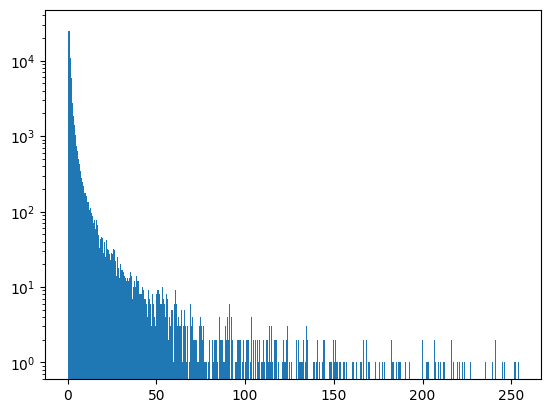

In [29]:
plt.yscale('log')
plt.hist(train.query('target_new <= 2**8')['target_new'],bins=2**10)

In [35]:
train.query('target_new >= 1000')

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_new
4459,2017-05-01,C_ID_700c15a07d,3,2,1,15.606405,49887.999907
4460,2017-01-01,C_ID_1c8a5b9d44,5,1,1,17.675716,209372.999440
5252,2017-08-01,C_ID_1b28c8af6b,3,2,1,14.855160,29638.000081
11921,2017-10-01,C_ID_648406c4c7,1,3,0,10.139105,1127.650908
15360,2016-08-01,C_ID_a21da11a50,5,1,1,11.315665,2548.910003
20798,2016-12-01,C_ID_48e3368518,5,2,1,10.196864,1173.712859
26075,2017-01-01,C_ID_4e1cd1689e,5,1,1,11.759035,3465.950007
28609,2017-11-01,C_ID_75bbf5a264,3,1,1,11.606558,3118.330010
37303,2017-06-01,C_ID_6f979811eb,5,2,1,13.310613,10159.999988
41325,2017-05-01,C_ID_a4e600deef,5,1,1,17.965068,255873.000873
